In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay)

import warnings
warnings.filterwarnings("ignore")


In [29]:
# Load dataset
df = pd.read_csv("heart_cleveland_upload.csv")
df.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0


In [31]:
# Check for missing values
df.isnull().sum()


age          0
sex          0
cp           0
trestbps     0
chol         0
fbs          0
restecg      0
thalach      0
exang        0
oldpeak      0
slope        0
ca           0
thal         0
condition    0
dtype: int64

In [33]:
# Define features and target
X = df.drop('condition', axis=1)
y = df['condition']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [35]:
svm_model = SVC(probability=True)
svm_params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}
svm_grid = GridSearchCV(svm_model, svm_params, cv=5, scoring='accuracy')
svm_grid.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=SVC(probability=True),
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy')

In [36]:
rf_model = RandomForestClassifier()
rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5]}
rf_grid = GridSearchCV(rf_model, rf_params, cv=5, scoring='accuracy')
rf_grid.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [37]:
gbm_model = GradientBoostingClassifier()
gbm_params = {'n_estimators': [50, 100, 150], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 4, 5]}
gbm_grid = GridSearchCV(gbm_model, gbm_params, cv=5, scoring='accuracy')
gbm_grid.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy')

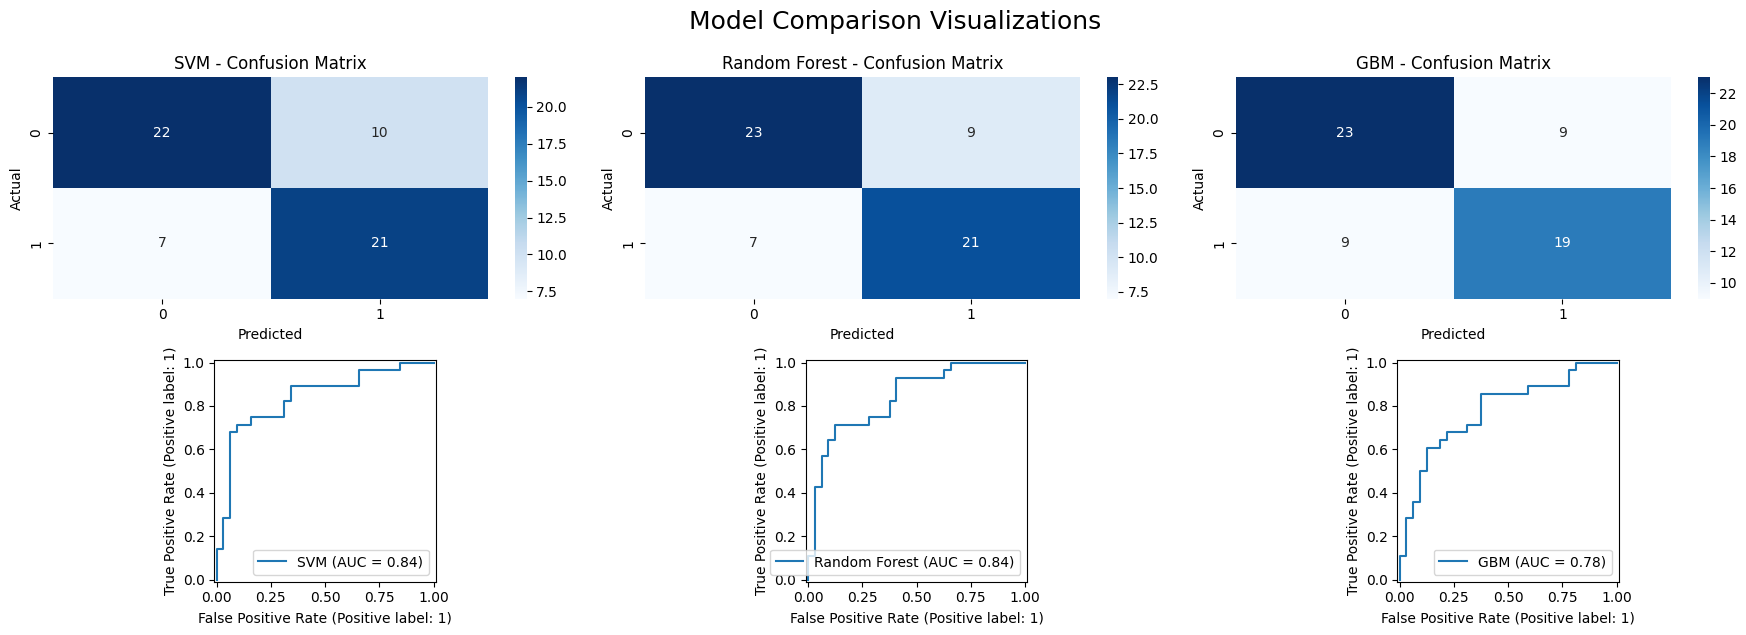

In [38]:
# Store models
models = {
    "SVM": svm_grid.best_estimator_,
    "Random Forest": rf_grid.best_estimator_,
    "GBM": gbm_grid.best_estimator_
}

# Visual comparison
plt.figure(figsize=(18, 6))
metrics_summary = []

for idx, (name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.subplot(2, 3, idx + 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    # ROC Curve
    plt.subplot(2, 3, idx + 4)
    RocCurveDisplay.from_estimator(model, X_test, y_test, ax=plt.gca(), name=name)

    # Save metrics
    metrics_summary.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "AUC-ROC": roc_auc_score(y_test, y_proba)
    })

plt.tight_layout()
plt.suptitle("Model Comparison Visualizations", fontsize=18, y=1.05)
plt.show()


In [39]:
# Display metrics as a summary table
results_df = pd.DataFrame(metrics_summary)
results_df.sort_values(by="F1 Score", ascending=False)


,Model,Accuracy,Precision,Recall,F1 Score,AUC-ROC
1,Random Forest,0.733333,0.700000,0.750000,0.724138,0.839286
0,SVM,0.716667,0.677419,0.750000,0.711864,0.838170
2,GBM,0.700000,0.678571,0.678571,0.678571,0.777902
